In [1]:
!pip install --upgrade -q tensorflow tensorflow-io

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.81 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
cudf 23.6.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
dask-cudf 23.6.1 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have 

In [3]:
import os
import cv2
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
import keras.backend as K
from time import perf_counter
import matplotlib.pyplot as plt
from keras import layers, models
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [7]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"
chest_xray = dataset / "chest-xray-pneumonia" / "chest_xray"
tb_chest = dataset / "tuberculosis-tb-chest-xray-dataset" / "TB_Chest_Radiography_Database"

In [8]:
class_mapping = defaultdict(list)

In [9]:
def append_file_names(directory, cls_name):
    """
    Append file names from a given directory to the corresponding class in the class_mapping dictionary.

    Args:
        directory (str): Directory path.
        cls_name (str): Name of the class.
    """
    for f_name in os.listdir(directory):
        if f_name.endswith((".jpeg", ".png")):
            class_mapping[cls_name].append(os.path.join(directory, f_name))

In [10]:
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    append_file_names(covid_19 / f"{covid19_class}" / 'images', f"{covid19_class}")

In [11]:
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test" / "PNEUMONIA",
                  chest_xray / "val" / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    for filename in os.listdir(source_dir):
        if filename.endswith(".jpeg"):
            if "bacteria" in filename:
                class_mapping["Bacterial Pneumonia"].append(os.path.join(source_dir, filename))

In [12]:
append_file_names(tb_chest / "Tuberculosis", "Tuberculosis")

In [13]:
classes = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 609890.49it/s]


In [14]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [15]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                      labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

Train samples: 15772
Validation samples: 3944
Test samples: 4929


In [16]:
BATCH_SIZE = 16

def image_generator(img_paths, img_labels, batch_s):
    """
    Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_s (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)
    while True:
        for offset in range(0, num_samples, batch_s):
            batch_paths = img_paths[offset:offset + batch_s]
            batch_labels = img_labels[offset:offset + batch_s]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(img_path)
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [17]:
train_generator = image_generator(train_paths, train_labels, BATCH_SIZE)
train_steps = len(train_paths) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [18]:
class NegativeImageLayer(layers.Layer):
    """
    Custom layer that converts an image into its negative representation.

    This layer takes an input image tensor and performs element-wise negation
    to obtain the negative representation of the image.
    """

    def __init__(self):
        """
        Initializes the NegativeImageLayer.
        """
        super(NegativeImageLayer, self).__init__()

    def build(self, input_shape):
        """
        Builds the NegativeImageLayer.

        This method is called when the layer is connected to the model and creates the layer's weights if necessary.

        Args:
            input_shape (tuple or tf.TensorShape): Shape of the input tensor.

        Returns:
            None
        """
        super(NegativeImageLayer, self).build(input_shape)

    @tf.function
    def call(self, inputs, **kwargs):
        """
        Performs element-wise negation of the input tensor to obtain the negative representation.

        Args:
            inputs (tf.Tensor): Input tensor representing the image.

        Returns:
            tf.Tensor: Negative representation of the input image tensor.
        """
        return tf.negative(inputs)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the layer.

        Args:
            input_shape (tuple or tf.TensorShape): Shape of the input tensor.

        Returns:
            tf.TensorShape: Output shape of the layer.
        """
        return super(NegativeImageLayer, self).compute_output_shape(input_shape)

In [20]:
inputs = layers.Input(shape=(224, 224, 3), name="Input")

# Block 1
x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(inputs)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv1")(x)
x = layers.BatchNormalization()(x)
blk1 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool1")(x)

# Block 2
x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(blk1)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv2")(x)
x = layers.BatchNormalization()(x)
blk2 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool2")(x)

# Block 3
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(blk2)
x = layers.MaxPooling2D(pool_size=2, strides=2, padding="same", name="MaxPool3")(x)
x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv3")(x)
x = layers.BatchNormalization()(x)
blk3 = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool4")(x)

# Block 4
x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(blk3)
x = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool5")(x)
x = layers.Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
x = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv4")(x)
blk4 = layers.BatchNormalization()(x)

# Block 5
y = NegativeImageLayer()(blk2)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool6")(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv7")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool7")(y)
y = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding="same", activation="relu", name="DConv5")(y)
y = layers.Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", name="Conv8")(y)
y = layers.MaxPooling2D(pool_size=2, strides=2, name="MaxPool8")(y)
y = layers.Conv2D(224, kernel_size=(3, 3), padding="same", activation="relu", name="Conv9")(y)
blk5 = layers.BatchNormalization()(y)


x = layers.Concatenate(name="DirectConcat")([blk4, blk5])

x = layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = layers.Dense(num_classes, activation="softmax", name="Output")(x)

model = models.Model(inputs=inputs, outputs=outputs)

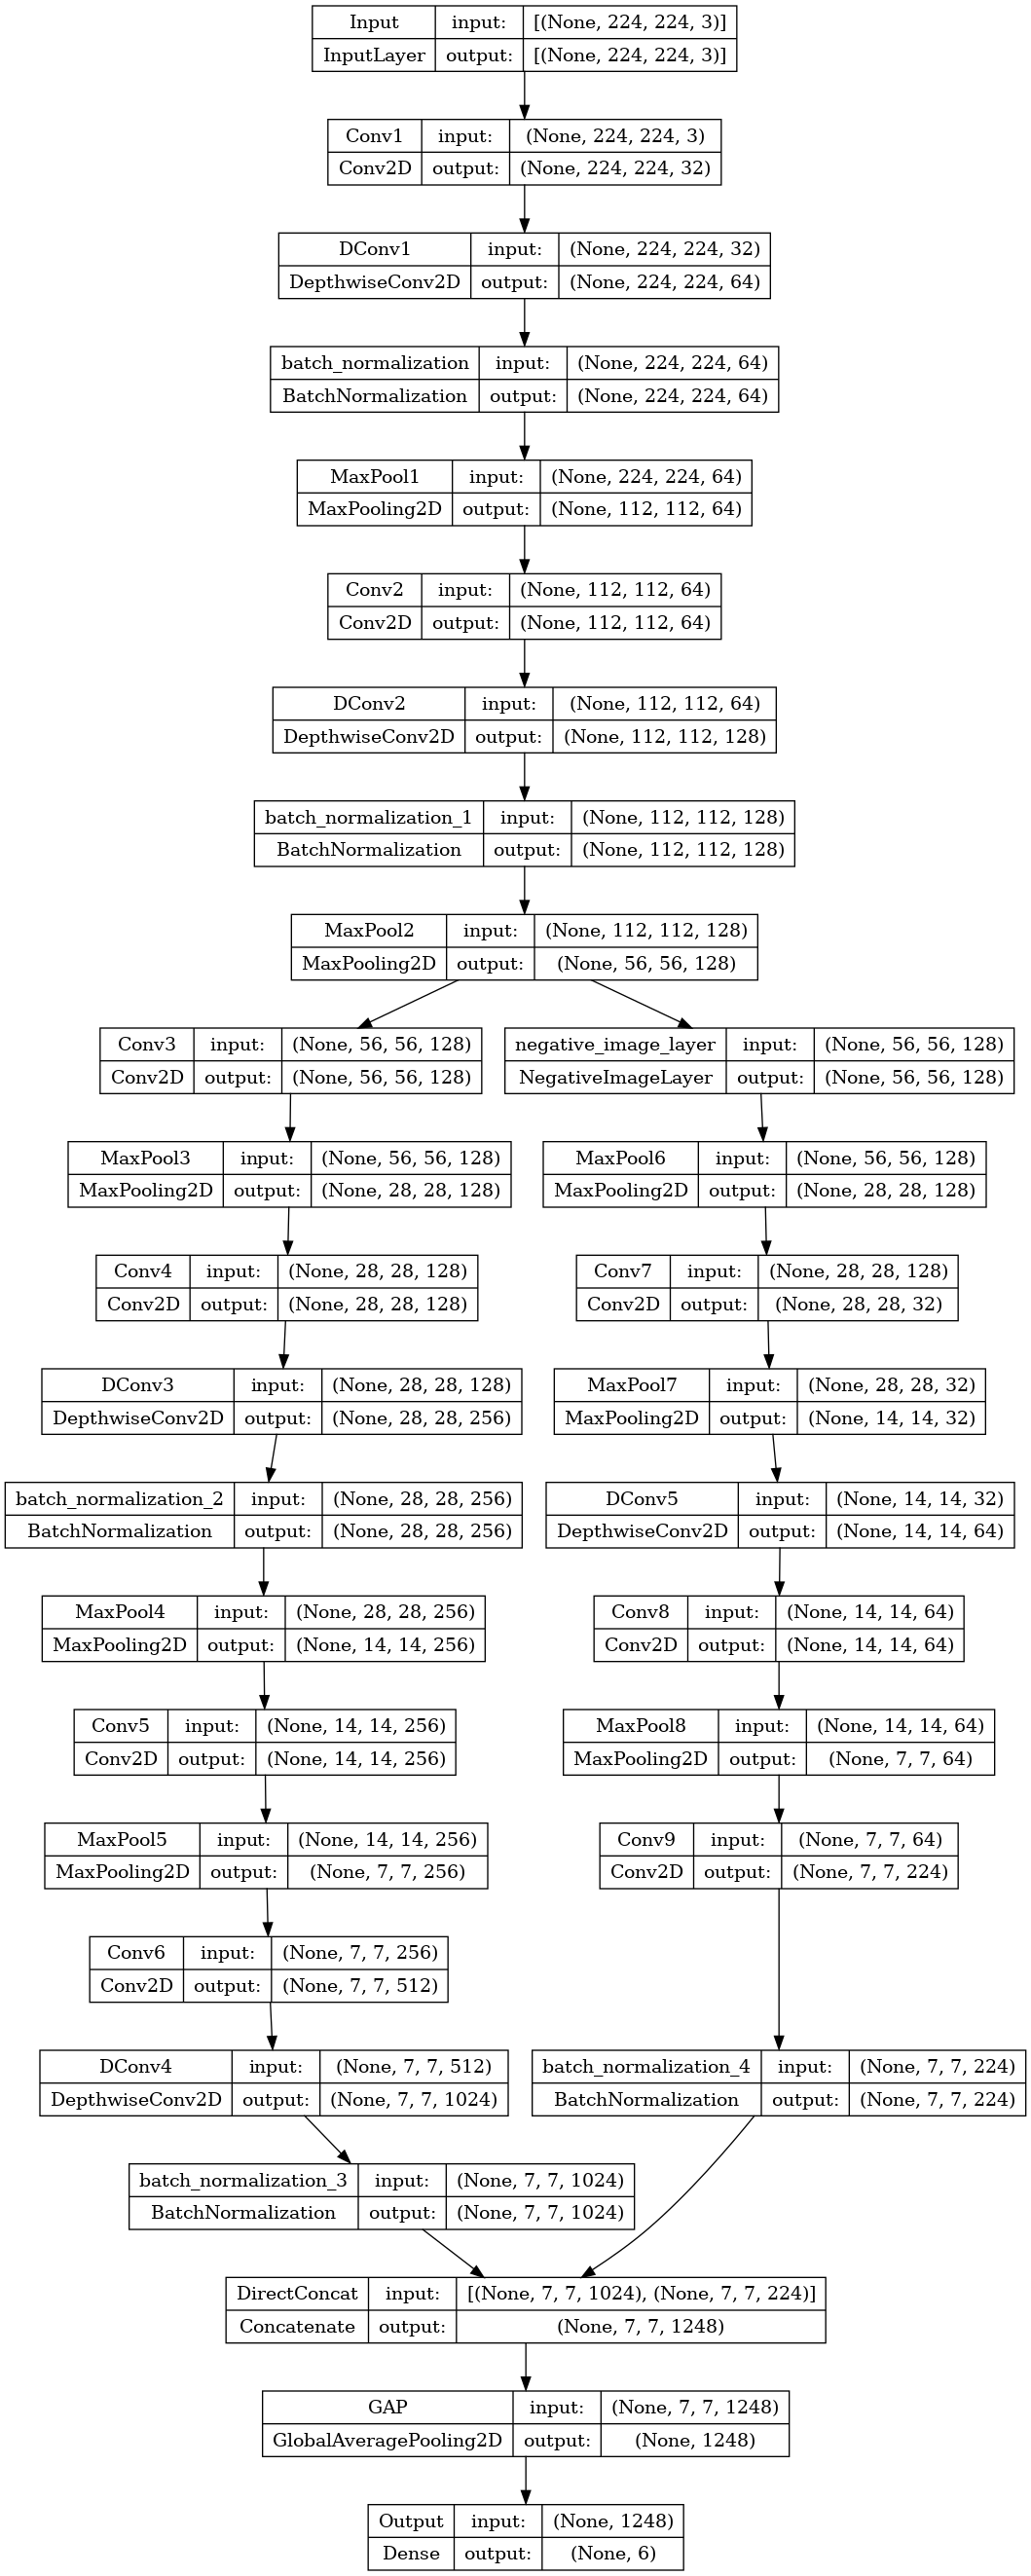

In [21]:
plot_model(model, show_shapes=True)

In [22]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [23]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', create_metrics()]
)

In [24]:
TOTAL_EPOCHS = 25
INITIAL_LEARNING_RATE = 0.75e-4
DECAY_RATE = 0.96

def learning_rate_scheduler(epoch, current_learning_rate):
    """
    A function that returns the learning rate for each epoch.

    Args:
        epoch (int): The current epoch.
        current_learning_rate (float): The current learning rate.

    Returns:
        float: The new learning rate.
    """
    if epoch < (TOTAL_EPOCHS / 3):
        new_learning_rate = INITIAL_LEARNING_RATE
    else:
        new_learning_rate = current_learning_rate * DECAY_RATE

    return new_learning_rate

In [25]:
learning_rate_callback = LearningRateScheduler(learning_rate_scheduler)

In [26]:
start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    callbacks=[learning_rate_callback],
    validation_data=val_generator,
    validation_steps=val_steps
)
end_time = perf_counter()

Epoch 1/25
985/985 [==============================] - 332s 318ms/step - loss: 0.6188 - accuracy: 0.7933 - precision: 0.8603 - recall: 0.7032 - f1_score: 0.7528 - specificity: 0.9772 - sensitivity: 0.7032 - mcc: 0.7257 - auc: 0.9616 - val_loss: 0.4702 - val_accuracy: 0.8321 - val_precision: 0.8484 - val_recall: 0.8031 - val_f1_score: 0.8243 - val_specificity: 0.9713 - val_sensitivity: 0.8031 - val_mcc: 0.7915 - val_auc: 0.9760 - lr: 7.5000e-05
Epoch 2/25
985/985 [==============================] - 143s 144ms/step - loss: 0.3131 - accuracy: 0.8930 - precision: 0.9073 - recall: 0.8765 - f1_score: 0.8909 - specificity: 0.9821 - sensitivity: 0.8765 - mcc: 0.8703 - auc: 0.9886 - val_loss: 0.2380 - val_accuracy: 0.9157 - val_precision: 0.9220 - val_recall: 0.9096 - val_f1_score: 0.9154 - val_specificity: 0.9846 - val_sensitivity: 0.9096 - val_mcc: 0.8989 - val_auc: 0.9932 - lr: 7.5000e-05
Epoch 3/25
985/985 [==============================] - 120s 122ms/step - loss: 0.2253 - accuracy: 0.9226 - 

In [27]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 50 minutes, 49 seconds, 871 milliseconds


In [28]:
_ = model.evaluate(test_generator, steps=test_steps)

308/308 [==============================] - 69s 225ms/step - loss: 0.4065 - accuracy: 0.9438 - precision: 0.9440 - recall: 0.9438 - f1_score: 0.9439 - specificity: 0.9888 - sensitivity: 0.9438 - mcc: 0.9327 - auc: 0.9813


In [29]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

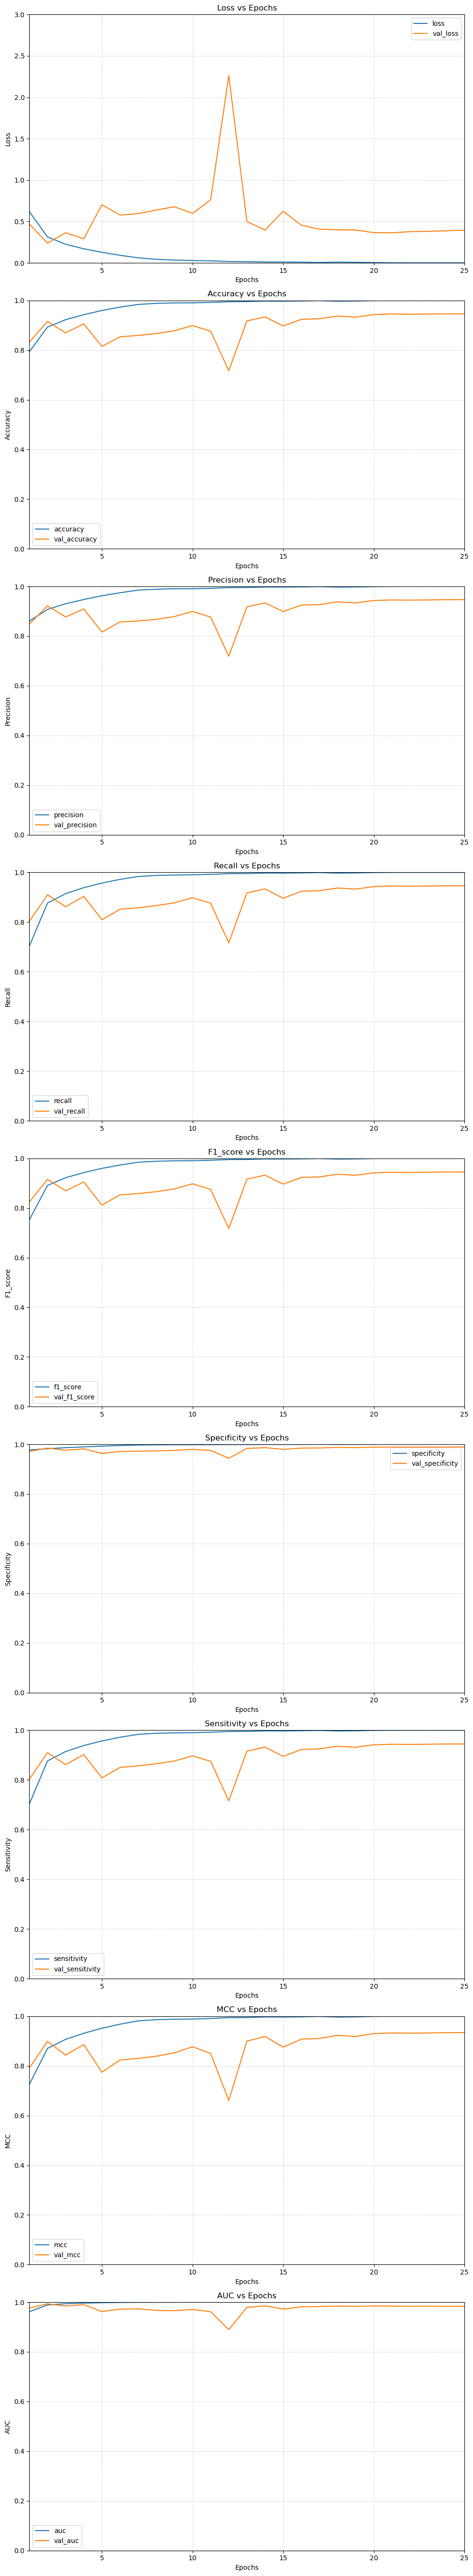

In [30]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
plot_metrics(history, metric_names)

In [31]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [32]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, classes
)

                     precision    recall  f1-score   support

Bacterial Pneumonia     0.9944    1.0000    0.9972       535
              COVID     0.9836    0.9650    0.9742       685
       Lung_Opacity     0.9052    0.8921    0.8986      1177
             Normal     0.9311    0.9463    0.9387      2086
       Tuberculosis     0.9931    0.9730    0.9829       148
    Viral Pneumonia     0.9784    0.9645    0.9714       282

           accuracy                         0.9436      4913
          macro avg     0.9643    0.9568    0.9605      4913
       weighted avg     0.9437    0.9436    0.9436      4913

There were 277 errors in 4913 tests for an accuracy of  94.36


In [33]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

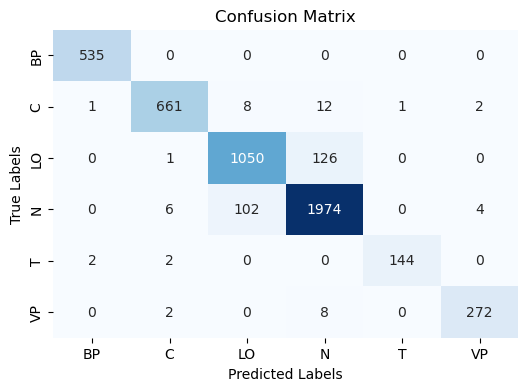

In [34]:
short_classes = []
for cls in classes:
    words = str(cls).replace('_', ' ').split()
    short_form = ''.join(word[0] for word in words)
    short_classes.append(short_form)

cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=short_classes, yticklabels=short_classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()